In [11]:
import bs4 as bs
import datetime as dt
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import pickle
import requests
import numpy as np

style.use('ggplot')

def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        tickers.append(ticker)
    
    with open('sp500tickers.pickle','wb') as f:
        pickle.dump(tickers, f)
        
    print(tickers)
    
    return tickers

#save_sp500_tickers()

In [7]:
# getting data from yahoo
def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start = dt.datetime(2000, 1, 1)
    end = dt.datetime(2016, 12, 31)
    
    for ticker in tickers[:25]:
        print(ticker)
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

get_data_from_yahoo()

MMM
ABT
ABBV
ABMD
ACN
ATVI
ADBE
AMD
AAP
AES
AMG
AFL
A
APD
AKAM
ALK
ALB
ARE
ALXN
ALGN
ALLE
AGN
ADS
LNT
ALL


In [5]:
# combining into one dataframe
def compile_data():
    with open('sp500tickers.pickle','rb') as f:
        tickers = pickle.load(f)
    
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers[:25]):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        
        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
        
        if main_df.empty:
            main_df = df
            
        else:
            main_df = main_df.join(df, how='outer')
        
        if count % 10 == 0:
            print(count)
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

compile_data()

0
10
20
                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
1999-12-31  28.304659  6.950151   NaN  18.37500  NaN  1.151060  16.561329   
2000-01-03  27.292488  6.698944   NaN  18.25000  NaN  1.235628  16.145748   
2000-01-04  26.208023  6.507545   NaN  17.81250  NaN  1.198042  14.791295   
2000-01-05  26.967150  6.495581   NaN  18.00000  NaN  1.202740  15.083735   
2000-01-06  29.136089  6.722870   NaN  18.03125  NaN  1.179249  15.206868   

                 AMD  AAP        AES    ...           ALK       ALB  \
Date                                    ...                           
1999-12-31  14.46875  NaN  30.397175    ...      7.913406  6.018779   
2000-01-03  15.50000  NaN  29.482208    ...      7.885243  5.646281   
2000-01-04  14.62500  NaN  28.313084    ...      7.786678  5.646281   
2000-01-05  15.00000  NaN  28.618069    ...      7.828921  5.744305   
2000-01-06  16.00000  NaN 

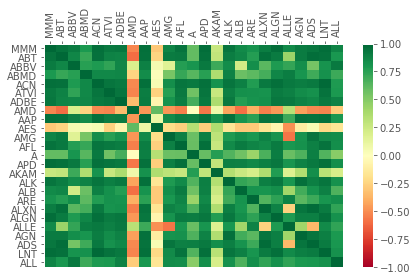

In [13]:
# visualizing the correlations
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    
    df_corr = df.corr() # calculates correlation values
    #print(df_corr.head())
    
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    
    plt.tight_layout()
    plt.show()

visualize_data()